# Status + LTD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import lines
import pandas as pd
import scipy.special
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
outputs_dir_test = Path("../../outputs/LtdStatus/outputs/test")
outputs_dir = Path("../../outputs/LtdStatus/outputs/sepa_0_2")

# Phase transition details

In [3]:
"""These functions present analytical solutions for the model. 
The parameter `label` can be one of the two values: Adam or Piotr. 
When it is Adam the `q` parameter is as it is in the paper, that is
it is the probability of the status dynamics. 
"""


def get_pb_crit(q, ph, label="adam"):
    """
    This function doesn't check if critical value exists. One needs to check beforehand. 
    """
    if label == "adam":
        q = 1-q
    return ((2*q + (1-q)*(1-2*ph))**2 / (8*q**2) + 1)/2

def get_rho_crit(q,ph, label="adam"):
    """
    This function doesn't check if critical value exists. One needs to check beforehand. 
    Basic assumption: pb_crit>0.5
    """
    if label == "adam":
        q = 1-q
    return 2*q/(2*q + (1-q)*(1-2*ph))

def get_pb_when_rho_eq_1(q, ph, label="adam"):
    """This function doesn't check if such pb exists. 

    Args:
        q (_type_): _description_
        ph (_type_): _description_
        label (str, optional): _description_. Defaults to "adam".
    """
    if label == "adam":
        q = 1-q
    return (3*q + (1-2*ph)*(1-q)) / (4*q)

def Delta(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return (2 *q + (1 -q)*(1 -2 *ph))** 2 - 4*(4 *pb *q -2 *q) *q

def afun(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return (4 *pb *q -2 *q)
def bfun(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return -2 *q - (1 -q)*(1 -2 *ph)
def cfun(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return q

def get_rhos(pb,ph,q, label="adam"):
    a = afun(pb, ph, q, label=label)
    b = bfun(pb, ph, q, label=label)
    c = cfun(pb, ph, q, label=label)
    
    if a == 0:
        return (-c / b, )
    
    d = Delta(pb, ph, q, label=label)
    if d < 0:
        if np.round(d, decimals = 15) < 0:
            return (np.nan, )
        else:
            d = np.round(d, decimals = 15)
    
    rho1 = (-b  - np.sqrt(d)) / 2 /a
    rho2 = (-b  + np.sqrt(d)) / 2 /a
    return sorted([rho1, rho2])
# rho2(pb,ph,q) = (2q + (1-q)(1-2ph) + sqrt(Delta(pb,ph,q))) / 2*(4pb*q-2q)

def get_quasi_rho(pb,ph,q, label="adam"):
    """Returns one value which is the level of quasi-stationary state if such a level exists. 
    Otherwise returns np.NaN

    Args:
        pb (_type_): _description_
        ph (_type_): _description_
        q (_type_): _description_
    """
    rhos = get_rhos(pb,ph,q, label=label)
    
    if len(rhos) == 1:
        if np.isnan(rhos[0]):
            return np.NaN
        elif (rhos[0] <= 1) & (rhos[0] >= 0):
            return rhos[0]
        else:
            return np.NaN
    
    if (rhos[0] <= 1) & (rhos[0] >= 0):
        if rhos[0] < rhos[1]: #rhos[0] is in proper range and is smaller. 
            rho_exp = rhos[0]
        elif (rhos[1] <= 1) & (rhos[1] >= 0): #rhos[1] is in proper range and is smaller. 
            rho_exp = rhos[1]
        else: #rhos[0] is in proper range and rhos[1] is not. 
            rho_exp = rhos[0]
    elif (rhos[1] <= 1) & (rhos[1] >= 0): #rhos[1] is in proper range and rhos[0] is not. 
        rho_exp = rhos[1]
    else:
        rho_exp = np.NaN
        
    return rho_exp

def get_separatrix(pbs, ph, q, label="adam"):
    """Returns rho values of separatrix (if exists) for given parameters

    Args:
        pbs (list or numpy.array): pb values
        ph (float): probabiilty ph
        q (float): probability q
    """
    
    rho_crits = np.zeros(len(pbs))
    for i, pb in enumerate(pbs):
        rhos_crit = get_rhos(pb, ph, q, label=label)
        
        no_sep_value = True
        if len(rhos_crit) == 2:
            if 0 < rhos_crit[0] < 1:
                if 0 < rhos_crit[1] < 1:
                    no_sep_value = False
                    rho_crits[i] = rhos_crit[1]
        if no_sep_value:
            rho_crits[i] = np.nan
    return rho_crits


In [16]:
q = 0.5
ph = 0.2
pbs = np.arange(0.895,0.923,0.0001)

rho_crits = get_separatrix(pbs, ph, q)


## Process data

In [20]:
import os, ast

def process_data(data, n_links, n_triads, k=1):
    for column in data.columns[k:-2]:
        data.loc[:, column] = data[column].str.split(',').map(lambda x: [int(float(x_el))/n_triads for x_el in x])
    data.loc[:, 'rho'] = data['rho'].str.split(',').map(lambda x: [int(float(x_el))/n_links for x_el in x])
    return data

def means_of_data(data, start, steps):
    df = pd.DataFrame(columns=data.columns)
    for _, row in data.iterrows():
        df = df.append(pd.DataFrame({
        'prob': row.p,
        'rho': row.rho[start:][::steps],
        'n0': row.n0[start:][::steps],
        'n1': row.n1[start:][::steps],
        'n2': row.n2[start:][::steps],
        'n3': row.n3[start:][::steps]
        }))
    df = df.groupby('prob').mean()
    return df

def get_rho_init(filename):
    with open(filename) as f:
        first_line = f.readline()
        spl = first_line.split("--rho-init', '")
        if len(spl) == 1:
            return 0.5
        else:
            strval = spl.split("'")[0]
            return float(strval)
        
def read_params(filename):
    params_d = {}
    with open(filename) as f:
        first_line = f.readline()
        # firstline = "# Commit: 126356fd51d619772e0c4137e13dfe116d309ebe# Arguments: ['main.py', 'LtdStatus', '-n', '100', '-p', '0.88', '-q', '0.5', '-ps', '0.25', '-s', '100', '-r', '1', '--rho-init', '0.9', '--ltd-agent-based', '--on-triad-status', 'outputs/test']"
        params = first_line.split("Arguments: ")[1]
        # params.strip('][').strip("'").split(', ')
        try:
            params = ast.literal_eval(params)
            isvalue = False
            last_key = ""
            for par in params:
                if par.startswith('--'):
                    if isvalue:
                        isvalue = False
                        # params_d[last_key] = True
                if not isvalue:
                    if par.startswith('--'):
                        par2 = par.strip("-")
                        par2 = par2.replace('-', '_')
                        params_d[par2] = True
                        isvalue = True
                        last_key = par2
                    elif par.startswith('-'):
                        par2 = par.strip("-")
                        par2 = par2.replace('-', '_')
                        params_d[par2] = np.NAN
                        isvalue = True
                        last_key = par2
                else:
                    isvalue = False
                    try:
                        if "." in par:
                            params_d[par2] = float(par)
                        else:
                            params_d[par2] = int(par)
                    except ValueError:
                        pass
        except (SyntaxError, ValueError):
            params = params.split("Namespace(")[1]
            params = params[:-1]
            params = params.split(',')
            params = list(map(lambda x: x.strip(), params))
            params = list(map(lambda x: x.split('='), params))
            keys = [param[0] for param in params]
            vals = [param[1] for param in params]
            for key, val in zip(keys, vals):
                if key == "steps":
                    key = "s"
                elif key == "n_agents":
                    key = "n"
                if val.startswith("'"):
                    params_d[key] = val
                    continue
                if val.startswith("["):
                    val = val[1:-1]
                try:
                    params_d[key] = int(val)
                except ValueError:
                    try:
                        params_d[key] = float(val)
                    except ValueError:
                        pass
                    
            
    return params_d

def process_folder(directory, no_triad_stats = True):
    files = [os.path.join(directory, dir, "outputs.tsv") for dir in os.listdir(directory)]
    
    df = pd.DataFrame({"q": [], "p": [], "ps": [], "rho_init": [], "steps": [],  "rho": [], "bp": []})
    usecols = ['q','p', 'ps', 'rho', 'bp']
    usecols_backup = ['q','p', 'ps', 'tr0', 'tr1']
    
    empty_folds = np.ones(len(files))
    reps = np.zeros(len(files), dtype = int)
    
    for i, file in enumerate(files):
        inilen = len(df)
        df2 = df.append(pd.read_csv(file,sep = '\t', comment='#', usecols = usecols))
        
        if type(np.array(df2.rho)[-1]) != str:
            if np.isnan(np.array(df2.rho)[-1]):
                """There is most likely error in columns. rho values are in another column"""
                df3 = pd.read_csv(file,sep = '\t', comment='#', usecols = usecols_backup)
                # df3.append(pd.read_csv(file,sep = '\t', comment='#', usecols = usecols_backup))
                df3_len = len(df3)
                df2_len = inilen+df3_len
                # print(df3)
                # print(df3_len)
                # print(df3.tr0.iloc[-df3_len:-1])
                # print(df3.tr0)
                # return df3, df2
                df2.loc[np.array(range(0,df2_len)) >= df2_len - df3_len, 'rho'] = df3["tr0"]
                df2.loc[np.array(range(0,df2_len)) >= df2_len - df3_len, 'bp'] = df3["tr1"]
                # print(df2)
                # for i, row in enumerate(df3.iterrows()):
                #     df2.rho.iloc[-i] = df3.tr0.iloc[-i]
                #     df2.bp.iloc[-i] = df3.tr1.iloc[-i]
        df = df2
        
        endlen = len(df)
        
        reps[i] = endlen - inilen
        
        if inilen == endlen:
            empty_folds[i] = False
    
    dicts = [read_params(file) for i, file in enumerate(files)]# if empty_folds[i] == 1]
    
    rho_inits_one = [round(d["rho_init"], 6) if "rho_init" in d else 0.5 for d in dicts]
    steps_one = [d["s"] for d in dicts]
    
    rho_inits = [rho_init for rho_init, rep in zip(rho_inits_one, reps) for _ in range(0,rep)]
    steps = [step for step, rep in zip(steps_one, reps) for _ in range(0,rep)]
    # print(df)
    # return df, rho_inits
    df.rho_init = rho_inits
    df.steps = steps
    
    df = df.dropna().reset_index()
    
    Ls_one = [d["n"]*(d["n"] - 1) for d in dicts]
    Ls = [L for L, rep in zip(Ls_one, reps) for _ in range(0,rep)]
    df.rho = np.array(df.rho.str.split(',').map(lambda x: [float(x_el) for x_el in x]))
    df["Lplus"] = df.rho
    df.rho = [np.array(rho) / L for rho, L in zip(df.rho, Ls)]
    
    return df

def group_results(df, cols):
    """group results according to (q,p,ps,rho_init,steps) anc check the outcome

    Args:
        df (_type_): _description_
    """
    mylist = dict()
    
    for group in df.groupby(cols):
        (group_label, df_temp) = group
        q = df.q[0]
        ps = df.ps[0]
        
        rho_crit = get_rho_crit(q, ps)
        
        reps = len(df_temp.rho)
        paradise = np.sum([rho[-1] == 1. for rho in df_temp.rho])
        quasi_stat = np.sum([rho[-1] < rho_crit for rho in df_temp.rho])
        other = np.array(reps) - paradise - quasi_stat
        
        paradise_ratio = paradise / (paradise + quasi_stat)
        
        d = dict(zip(cols, group_label))
        
        d.update({"repetitions": reps, "paradise": paradise, "quasi_stat": quasi_stat, "other": other, "paradise_ratio": paradise_ratio})
        mylist.update({group_label: d})
    
    return pd.DataFrame(data = mylist.values(), index = mylist.keys(), columns = [*cols, 'repetitions', 'paradise', 'quasi_stat', 'other', 'paradise_ratio'])
    

In [61]:
inds = np.where(df.rho_init != rho_inits)[0]
np.max(np.abs([np.array(df.rho_init)[ind] - rho_inits[ind] for ind in inds]))

1.1102230246251565e-16

In [50]:
# df, rho_inits = process_folder(outputs_dir_test)
df = process_folder(outputs_dir)
df

,index,q,p,ps,rho_init,steps,rho,bp,Lplus
0,0,0.5,0.904,0.2,0.89,400,"[0.8939393939393939, 0.8909090909090909, 0.887...",2604.0,"[8850.0, 8820.0, 8790.0, 8734.0, 8670.0, 8572...."
1,1,0.5,0.904,0.2,0.89,400,"[0.8947474747474747, 0.8909090909090909, 0.894...",2762.0,"[8858.0, 8820.0, 8852.0, 8850.0, 8830.0, 8766...."
2,2,0.5,0.904,0.2,0.89,400,"[0.8943434343434343, 0.8955555555555555, 0.893...",2709.0,"[8854.0, 8866.0, 8842.0, 8882.0, 8851.0, 8882...."
3,3,0.5,0.904,0.2,0.89,400,"[0.898080808080808, 0.8985858585858586, 0.8960...",2643.0,"[8891.0, 8896.0, 8871.0, 8889.0, 8897.0, 8924...."
4,4,0.5,0.904,0.2,0.89,400,"[0.8867676767676768, 0.8853535353535353, 0.880...",2574.0,"[8779.0, 8765.0, 8721.0, 8761.0, 8798.0, 8736...."
...,...,...,...,...,...,...,...,...,...
64678,95,0.5,0.918,0.2,0.95,400,"[0.951010101010101, 0.9515151515151515, 0.9545...",4950.0,"[9415.0, 9420.0, 9450.0, 9432.0, 9385.0, 9400...."
64679,96,0.5,0.918,0.2,0.95,400,"[0.9488888888888889, 0.9488888888888889, 0.947...",4950.0,"[9394.0, 9394.0, 9381.0, 9383.0, 9407.0, 9419...."
64680,97,0.5,0.918,0.2,0.95,400,"[0.951010101010101, 0.9563636363636364, 0.9594...",4950.0,"[9415.0, 9468.0, 9499.0, 9533.0, 9547.0, 9560...."
64681,98,0.5,0.918,0.2,0.95,400,"[0.9489898989898989, 0.9561616161616162, 0.957...",4950.0,"[9395.0, 9466.0, 9478.0, 9495.0, 9534.0, 9489...."


In [51]:
df_g = group_results(df, ['q', 'p', 'ps', 'rho_init'])
df_g

q      p   ps  rho_init  repetitions  paradise  \
0.5 0.870 0.2 0.85  0.5  0.870  0.2      0.85          100         0   
              0.86  0.5  0.870  0.2      0.86          100         0   
              0.87  0.5  0.870  0.2      0.87          100         0   
              0.88  0.5  0.870  0.2      0.88            5         0   
              0.90  0.5  0.870  0.2      0.90          100         0   
...                 ...    ...  ...       ...          ...       ...   
    0.923 0.2 0.95  0.5  0.923  0.2      0.95          100       100   
              0.96  0.5  0.923  0.2      0.96          100       100   
              0.97  0.5  0.923  0.2      0.97          100       100   
              0.98  0.5  0.923  0.2      0.98          100       100   
              0.99  0.5  0.923  0.2      0.99          100       100   

                    quasi_stat  other  paradise_ratio  
0.5 0.870 0.2 0.85         100      0             0.0  
              0.86         100      0             0.0  
              0.87         100      0             0.0  
              0.88           5      0             0.0  
              0.90         100      0             0.0  
...                        ...    ...             ...  
    0.923 0.2 0.95           0      0             1.0  
              0.96           0      0             1.0  
              0.97           0      0             1.0  
              0.98           0      0             1.0  
              0.99           0      0             1.0  

[661 rows x 9 columns]

# Plotting phase diagram

In [52]:
df_pivoted = df_g.pivot(columns='p', index='rho_init', values='paradise_ratio')

Text(0, 0.5, '$\\sin (\\theta)$')

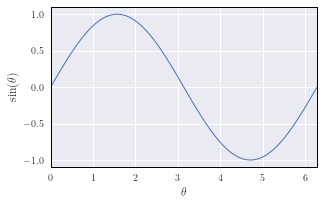

In [42]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

import numpy as np
import matplotlib.pyplot as plt

# Using seaborn's style
plt.style.use('seaborn')
width = 345
# width = 1000

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams.update(tex_fonts)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4

x = np.linspace(0, 2*np.pi, 100)
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# Plot
ax.plot(x, np.sin(x))
ax.set_xlim(0, 2 * np.pi)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\sin (\theta)$')



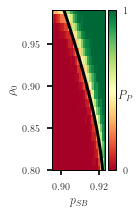

In [66]:
save_ = True

figsize = set_size(width)
figsize = (figsize[0]/4, figsize[1])

# fig, ax = plt.subplots(figsize=(10, 6))
fig, ax = plt.subplots(figsize=figsize)

colormesh = ax.pcolormesh(df_pivoted.columns, df_pivoted.index, df_pivoted, cmap='RdYlGn')

ax.tick_params(axis='x', which='major',  length=5, width=2)
ax.tick_params(axis='y', which='major',  length=5, width=2)
# ax.xaxis.grid(True, which='minor')
# ax.set_xticks(df_pivoted.columns[::6])
ax.set_xticks([0.9,  0.92])
ax.set_yticks(df_pivoted.index[::5])

ax.set_xlim([0.895, 0.923])
ax.set_ylim([0.8, 0.99])

cbar = fig.colorbar(colormesh,ax = ax)

ax.plot(pbs, rho_crits, color='black', linewidth=3)

ax.set_xlabel(r'$p_{SBT}$')
ax.set_ylabel(r'$\rho_0$')
# ax.set_xlabel('p_SB')

# cbar.set_label(r"Probability of reaching paradise")
cbar.set_label(r"$P_P$", labelpad=-4, rotation='horizontal')
# cbar.set_label(r"Paradise probability", labelpad=-5)
cbar.set_ticks([0., 1.])

if save_:
    # Save and remove excess whitespace
    # fig.tight_layout()
    fig.savefig('separatrix_0_2' + '.pdf', format='pdf', bbox_inches='tight') 

In [37]:
cbar.get_ticks()
cbar.set_ticks([0., 1.])

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [22]:
np.unique(df.rho_init)
# df_pivoted

array([0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 ,
       0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])

# Analysis of intermediate rho values

In [9]:
rho_univals = np.unique([rho for rhos in df.rho for rho in rhos])
len(rho_univals), min(rho_univals), max(rho_univals)

(5123, 0.47404040404040404, 1.0)

In [10]:
L = 100*99
vals = np.arange(min(rho_univals),max(rho_univals)+1/L,1/L)

np.max([np.min(np.abs(vals - val)) for val in rho_univals])

3.4416913763379853e-15

In [11]:
def group_series(df, cols):
    """group results according to (q,p,ps) and analyze time series to see what is the outcome if given rho is reached

    Args:
        df (_type_): _description_
    """
    Lplus_univals = np.unique([rho for rhos in df.Lplus for rho in rhos])
    mylist = dict()
    
    for group in df.groupby(cols):
        (group_label, df_temp) = group
        q = df.q[0]
        ps = df.ps[0]
        
        rho_crit = get_rho_crit(q, ps)
        
        reps = len(df_temp.rho)
        
        # Lplus_to_paradise = np.zeros(len(Lplus_univals))
        Lplus_to_par_dict = dict.fromkeys(Lplus_univals, 0)
        Lplus_to_qs_dict = dict.fromkeys(Lplus_univals, 0)
        for series, rhos in zip(df_temp.Lplus, df_temp.rho):
            # print(series)
            for Lplus in series:
                if rhos[-1] == 1.:
                    Lplus_to_par_dict[Lplus] += 1
                elif rhos[-1] < rho_crit:
                    Lplus_to_qs_dict[Lplus] += 1
            #     else:
            #         print(Lplus)
            # return Lplus_to_par_dict, series, rho_crit
        
        for Lplus in Lplus_univals:
            s = Lplus_to_par_dict[Lplus] + Lplus_to_qs_dict[Lplus]
            if s > 0:
                Lplus_to_par_dict[Lplus] = Lplus_to_par_dict[Lplus] / s
                Lplus_to_qs_dict[Lplus] /= s
            else:
                Lplus_to_par_dict[Lplus] = np.nan
                Lplus_to_qs_dict[Lplus] = np.nan
        
        d = dict(zip(cols, group_label))
        
        d.update({"repetitions": reps, "paradise": Lplus_to_par_dict, "quasi_stat": Lplus_to_qs_dict})
        mylist.update({group_label: d})
    
    return pd.DataFrame(data = mylist.values(), index = mylist.keys(), columns = [*cols, 'repetitions', 'paradise', 'quasi_stat'])

def group_series_trans_vals(df, cols, granularity = False, L = 9900, keep_trans_mat = True):
    """group results according to (q,p,ps) and analyze time series to see what rho values follow what values
    granularity defines whether we should take all possible rho values or there should be some range of values that we care 
    granularity =[0.8, 0.81, 0.82, 0.83, 0.84] defines bins. It would give 6 bins: (, 0.8), [0.8, 0.81), ..., [0.84,)
    L is the number of edges

    Args:
        df (_type_): _description_
    """
    if type(granularity) == bool:
        Lplus_univals = np.unique([rho for rhos in df.Lplus for rho in rhos])
        centers = Lplus_univals
    else:
        if np.any((np.array(granularity) < 1) & (np.array(granularity) > 0)):
            granularity *= L
        
        # if granularity[0] != 0:
        #     granularity = np.insert(granularity,0,0)
        if granularity[-1] != L+1:
            granularity = np.append(granularity,L+1)
        
        
        centers = (granularity[0:len(granularity)-1] + granularity[1:len(granularity)])/2
        centers = np.insert(centers, 0, centers[0] - (centers[1] - centers[0]))
        if centers[-1] > L:
            centers[-1] = L
    mylist = dict()
    
    for group in df.groupby(cols):
        (group_label, df_temp) = group
        q = df.q[0]
        ps = df.ps[0]
        
        rho_crit = get_rho_crit(q, ps)
        
        reps = len(df_temp.rho)
        
        # Lplus_to_paradise = np.zeros(len(Lplus_univals))
        if type(granularity) == bool:
            rho_follow = np.zeros([len(Lplus_univals), len(Lplus_univals)])
            Lplus_counts = dict.fromkeys(Lplus_univals, 0)
        else:
            rho_follow = np.zeros([len(granularity), len(granularity)])
            Lplus_counts = dict.fromkeys(granularity, 0)
        for series, rhos in zip(df_temp.Lplus, df_temp.rho):
            # print(series)
            Lplus_bef = -1
            ind_bef = -1
            for i, Lplus in enumerate(series):
                if type(granularity) == bool:
                    ind = np.where(Lplus == Lplus_univals)[0][0]
                else:
                    ind = np.where(Lplus < granularity)[0][0]
                if i == 0:
                    Lplus_bef = Lplus
                    ind_bef = ind
                    continue
                if type(granularity) == bool:
                    Lplus_counts[Lplus_bef] += 1
                else:
                    Lplus_counts[granularity[ind_bef]] += 1
                rho_follow[ind_bef, ind] += 1
                Lplus_bef = Lplus
                ind_bef = ind
        # return Lplus_counts, rho_follow, df_temp.Lplus
        
        if type(granularity) == bool:
            seq = Lplus_univals
        else:
            seq = granularity
        for i, Lplus in enumerate(seq):
            s = Lplus_counts[Lplus]
            if s > 0:
                rho_follow[i,:] = rho_follow[i,:] / s
            else:
                rho_follow[i,:] = np.nan
        
        mean_follow = np.zeros(rho_follow.shape[0])
        std_follow = np.zeros(rho_follow.shape[0])
        for i, Lplus in enumerate(seq):
            val = rho_follow[i,:]
            cnt = Lplus_counts[Lplus]
            mean_follow[i] = sum(val*centers)
            # std_follow[i] = np.sqrt(np.mean((val*cnt*centers - cnt*mean_follow[i])**2))
            # V = np.mean(val*cnt*centers**2) - mean_follow[i]**2
            # if V < 0:
                # return val,cnt, centers, mean_follow[i]
            std_follow[i] = np.sqrt(np.sum(val*cnt*centers**2)/cnt - mean_follow[i]**2)
        
        d = dict(zip(cols, group_label))
        d.update({"repetitions": reps, "counts": Lplus_counts, "mean_follow": mean_follow, "std_follow": std_follow})
        if keep_trans_mat:
            d.update({"follows": rho_follow})
        mylist.update({group_label: d})
    
    if keep_trans_mat:
        return pd.DataFrame(data = mylist.values(), index = mylist.keys(), columns = [*cols, 'repetitions', 'counts', 'follows', 'mean_follow', 'std_follow'])
    else:
        return pd.DataFrame(data = mylist.values(), index = mylist.keys(), columns = [*cols, 'repetitions', 'counts', 'mean_follow', 'std_follow'])
    

In [12]:
ser_g = group_series(df, ['q', 'p', 'ps'])
ser_g

q      p    ps  repetitions  \
0.5 0.750 0.25  0.5  0.750  0.25           52   
    0.800 0.25  0.5  0.800  0.25            2   
    0.830 0.25  0.5  0.830  0.25          200   
    0.840 0.25  0.5  0.840  0.25          200   
    0.850 0.25  0.5  0.850  0.25          202   
    0.860 0.25  0.5  0.860  0.25          200   
    0.870 0.25  0.5  0.870  0.25          201   
    0.875 0.25  0.5  0.875  0.25          375   
    0.876 0.25  0.5  0.876  0.25          390   
    0.877 0.25  0.5  0.877  0.25          398   
    0.878 0.25  0.5  0.878  0.25          415   
    0.879 0.25  0.5  0.879  0.25          439   
    0.880 0.25  0.5  0.880  0.25         1367   
    0.881 0.25  0.5  0.881  0.25         1106   
    0.882 0.25  0.5  0.882  0.25         1104   
    0.883 0.25  0.5  0.883  0.25         1109   
    0.884 0.25  0.5  0.884  0.25         1300   
    0.885 0.25  0.5  0.885  0.25         1100   
    0.886 0.25  0.5  0.886  0.25         1100   
    0.887 0.25  0.5  0.887  0.25         1300   
    0.888 0.25  0.5  0.888  0.25         1200   
    0.889 0.25  0.5  0.889  0.25         1209   
    0.890 0.25  0.5  0.890  0.25         1775   

                                                         paradise  \
0.5 0.750 0.25  {4693.0: 0.0, 4701.0: 0.0, 4712.0: 0.0, 4717.0...   
    0.800 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.830 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.840 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.850 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.860 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.870 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.875 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.876 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.877 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.878 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.879 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.880 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.881 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.882 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.883 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.884 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.885 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.886 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.887 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.888 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.889 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   
    0.890 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...   

                                                       quasi_stat  
0.5 0.750 0.25  {4693.0: 1.0, 4701.0: 1.0, 4712.0: 1.0, 4717.0...  
    0.800 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...  
    0.830 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...  
    0.840 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...  
    0.850 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...  
    0.860 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...  
    0.870 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...  
    0.875 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...  
    0.876 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...  
    0.877 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...  
    0.878 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...  
    0.879 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...  
    0.880 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...  
    0.881 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...  
    0.882 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...  
    0.883 0.25  {4693.0: nan, 4701.0: nan, 4712.0: nan, 4717.0...  
    0.884 0.25  {4693.0: nan

In [13]:
data = np.zeros([len(np.unique(ser_g.p)), len(rho_univals)])

i=0
for index, row in ser_g.iterrows():
    data[i,:] = list(row.paradise.values())
    i += 1
data

array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.]])

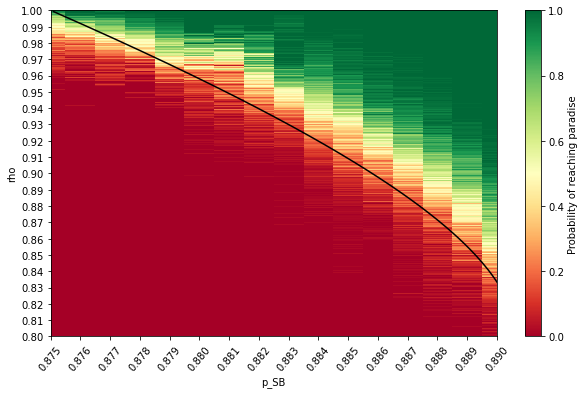

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

colormesh = ax.pcolormesh(ser_g.p, rho_univals, data.transpose(), cmap='RdYlGn')

ax.tick_params(axis='x', which='major', rotation=50)
ax.set_xticks(df_pivoted.columns)
# ax.set_yticks(df_pivoted.index)
ax.set_yticks(np.arange(0.8, 1.01, 0.01))

ax.set_xlim([0.875, 0.89])
ax.set_ylim([0.8, 1.])
# ax.set_ylim([0.8)

cbar = fig.colorbar(colormesh,ax = ax)

ax.plot(pbs, rho_crits, color='black')

ax.set_xlabel('p_SB')
ax.set_ylabel('rho')
# ax.set_xlabel('p_SB')

cbar.set_label("Probability of reaching paradise")

## Get transitions from state to state

In [19]:
g = 0.001
granularity=np.arange(0.7, 1., g)
trans_g = group_series_trans_vals(df, ['q', 'p', 'ps'], granularity=granularity, keep_trans_mat=False)
trans_g

q      p    ps  repetitions  \
0.5 0.800 0.25  0.5  0.800  0.25            2   
    0.830 0.25  0.5  0.830  0.25          200   
    0.840 0.25  0.5  0.840  0.25          200   
    0.850 0.25  0.5  0.850  0.25          202   
    0.860 0.25  0.5  0.860  0.25          200   
    0.870 0.25  0.5  0.870  0.25          201   
    0.875 0.25  0.5  0.875  0.25            1   
    0.880 0.25  0.5  0.880  0.25         1367   
    0.881 0.25  0.5  0.881  0.25         1106   
    0.882 0.25  0.5  0.882  0.25         1104   
    0.883 0.25  0.5  0.883  0.25         1109   
    0.884 0.25  0.5  0.884  0.25         1300   
    0.885 0.25  0.5  0.885  0.25         1100   
    0.886 0.25  0.5  0.886  0.25         1100   
    0.887 0.25  0.5  0.887  0.25         1300   
    0.888 0.25  0.5  0.888  0.25         1200   
    0.889 0.25  0.5  0.889  0.25         1209   
    0.890 0.25  0.5  0.890  0.25         1775   

                                                           counts  \
0.5 0.800 0.25  {6930.0: 284, 6939.9: 0, 6949.799999999999: 0,...   
    0.830 0.25  {6930.0: 77524, 6939.9: 18, 6949.799999999999:...   
    0.840 0.25  {6930.0: 77049, 6939.9: 12, 6949.799999999999:...   
    0.850 0.25  {6930.0: 76699, 6939.9: 15, 6949.799999999999:...   
    0.860 0.25  {6930.0: 75125, 6939.9: 32, 6949.799999999999:...   
    0.870 0.25  {6930.0: 72818, 6939.9: 61, 6949.799999999999:...   
    0.875 0.25  {6930.0: 49, 6939.9: 0, 6949.799999999999: 0, ...   
    0.880 0.25  {6930.0: 283244, 6939.9: 7724, 6949.7999999999...   
    0.881 0.25  {6930.0: 187105, 6939.9: 6666, 6949.7999999999...   
    0.882 0.25  {6930.0: 144496, 6939.9: 6398, 6949.7999999999...   
    0.883 0.25  {6930.0: 102754, 6939.9: 5737, 6949.7999999999...   
    0.884 0.25  {6930.0: 71580, 6939.9: 4780, 6949.79999999999...   
    0.885 0.25  {6930.0: 35693, 6939.9: 2875, 6949.79999999999...   
    0.886 0.25  {6930.0: 16713, 6939.9: 1650, 6949.79999999999...   
    0.887 0.25  {6930.0: 8707, 6939.9: 1014, 6949.799999999999...   
    0.888 0.25  {6930.0: 2213, 6939.9: 320, 6949.799999999999:...   
    0.889 0.25  {6930.0: 634, 6939.9: 62, 6949.799999999999: 1...   
    0.890 0.25  {6930.0: 193, 6939.9: 39, 6949.799999999999: 4...   

                                                      mean_follow  \
0.5 0.800 0.25  [6925.05, nan, nan, nan, nan, 6925.05, nan, na...   
    0.830 0.25  [6925.05, 6925.599999999999, 6926.797058823529...   
    0.840 0.25  [6925.0510279173, 6925.05, 6925.05, 6928.54411...   
    0.850 0.25  [6925.0501290759985, 6925.05, 6927.525, 6929.5...   
    0.860 0.25  [6925.056325457571, 6929.071875000001, 6928.76...   
    0.870 0.25  [6925.086436046033, 6937.546721311475, 6944.30...   
    0.875 0.25  [6926.6663265306115, nan, nan, nan, 6925.05, n...   
    0.880 0.25  [6927.428217367358, 6948.56185914034, 6954.349...   
    0.881 0.25  [6928.250244247882, 6950.143069306933, 6955.46...   
    0.882 0.25  [6929.076636723507, 6950.483932478898, 6956.72...   
    0.883 0.25  [6930.0791969169095, 6952.822459473594, 6959.2...   
    0.884 0.25  [6931.349874266552, 6954.511820083682, 6960.85...   
    0.885 0.25  [6932.739121116187, 6956.530278260871, 6961.83...   
    0.886 0.25  [6934.620651588583, 6958.469999999999, 6964.90...   
    0.887 0.25  [6935.509411967381, 6957.698520710058, 6966.70...   
    0.888 0.25  [6938.698847718032, 6958.771874999999, 6970.58...   
    0.889 0.25  [6938.963091482648, 6961.137096774194, 6968.64...   
    0.890 0.25  [6939.823056994818, 6964.3961538461535, 6954.9...   

                                                       std_follow  
0.5 0.800 0.25  [0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, ...  
    0.830 0.25  [0.0, 2.267708096980963, 6.988235294367918, 0....  
    0.840 0.25  [0.22556782108899992, 0.0, 0.0, 13.97647058793...  
    0.850 0.25  [0.0357469107420181, 0.0, 8.2086463566379, 13....  
    0.860 0.25  [0.5183752219933484, 13.06354025469984, 17.804...  
    0.870 0.25  [1.4373811434246186, 26.64309935713228

100 0.9579968955795382 0.8799999999999989 0.88
110 0.9489594282831383 0.8809999999999988 0.881
120 0.9396215682003183 0.8819999999999987 0.882
130 0.9299232976277753 0.8829999999999986 0.883
140 0.9197839882558736 0.8839999999999985 0.884
150 0.9090909090909274 0.8849999999999983 0.885
160 0.8976779178027116 0.8859999999999982 0.886
170 0.8852816187260728 0.8869999999999981 0.887
180 0.8714365384404907 0.887999999999998 0.888
190 0.8551558981253501 0.8889999999999979 0.889
200 0.8333333333333945 0.8899999999999978 0.89


Text(0, 0.5, '$\\overline{\\Delta\\rho}$')

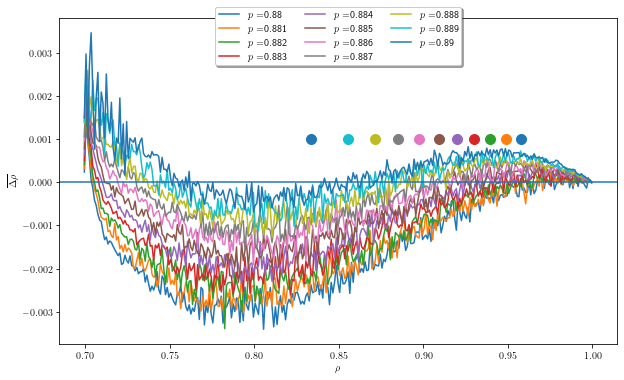

In [21]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize=(10, 6))

centers = (granularity[0:len(granularity)-1] + granularity[1:len(granularity)])/2
centers = np.insert(centers, 0, centers[0] - (centers[1] - centers[0]))
centers = np.append(centers, centers[-1] + (centers[-1] - centers[-2]))
if centers[-1] > L:
    centers[-1] = L

x = centers

for ind, row in trans_g.iterrows():
    if row.repetitions < 100:
        continue
    p = ind[1]
    if p < 0.88:
        continue
    y = row.mean_follow
    
    line, = plt.plot(x/L, (y-x)/L, label = r"$p=$"+str(p))    
    
    ind = np.where(np.abs(pbs-p) == np.min(np.abs(pbs-p)))[0][0]
    print(ind, rho_crits[ind],pbs[ind],p)
    plt.scatter(rho_crits[ind],0.001, color=line.get_color(), s = 100)

plt.axhline(y = 0)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\overline{\Delta\rho}$")
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
# plt.
# for 

100 0.9579968955795382 0.8799999999999989 0.88
110 0.9489594282831383 0.8809999999999988 0.881
120 0.9396215682003183 0.8819999999999987 0.882
130 0.9299232976277753 0.8829999999999986 0.883
140 0.9197839882558736 0.8839999999999985 0.884
150 0.9090909090909274 0.8849999999999983 0.885
160 0.8976779178027116 0.8859999999999982 0.886
170 0.8852816187260728 0.8869999999999981 0.887
180 0.8714365384404907 0.887999999999998 0.888
190 0.8551558981253501 0.8889999999999979 0.889
200 0.8333333333333945 0.8899999999999978 0.89


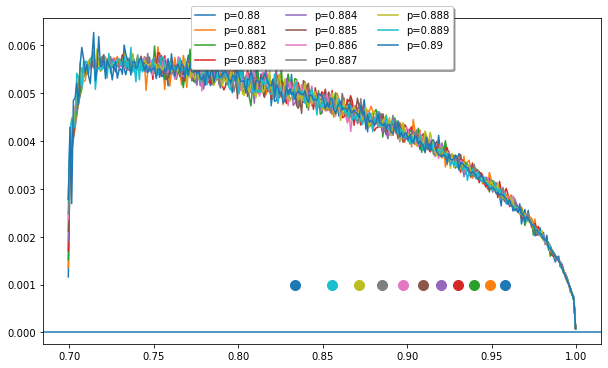

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

centers = (granularity[0:len(granularity)-1] + granularity[1:len(granularity)])/2
centers = np.insert(centers, 0, centers[0] - (centers[1] - centers[0]))
centers = np.append(centers, centers[-1] + (centers[-1] - centers[-2]))
if centers[-1] > L:
    centers[-1] = L

x = centers

for ind, row in trans_g.iterrows():
    if row.repetitions < 100:
        continue
    p = ind[1]
    if p < 0.88:
        continue
    y = row.std_follow
    
    line, = plt.plot(x/L, y/L, label = "p="+str(p))    
    
    ind = np.where(np.abs(pbs-p) == np.min(np.abs(pbs-p)))[0][0]
    print(ind, rho_crits[ind],pbs[ind],p)
    plt.scatter(rho_crits[ind],0.001, color=line.get_color(), s = 100)

plt.axhline(y = 0)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
# plt.
# for 

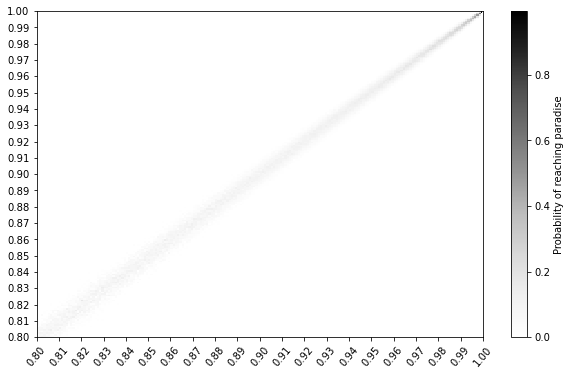

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))

data = trans_g.loc[(0.5, 0.887, 0.25)].follows
# granularity=np.arange(0.7, 1., 0.01)
# centers = np.arange(0.7+0.005,1,0.01)
# centers2 = np.append(centers, 1)
# centers2 = np.insert(centers2, 0, 0.69)

colormesh = ax.pcolormesh(centers2, centers2, data.transpose(), cmap = 'Greys')#, cmap='RdYlGn')

ax.tick_params(axis='x', which='major', rotation=50)
# ax.set_xticks(df_pivoted.columns)
ax.set_xticks(np.arange(0.7, 1.01, 0.01))
# ax.set_yticks(df_pivoted.index)
ax.set_yticks(np.arange(0.7, 1.01, 0.01))

ax.set_xlim([0.8, 1])
ax.set_ylim([0.8, 1])
# ax.set_ylim([0.8)

cbar = fig.colorbar(colormesh,ax = ax)

# ax.plot(pbs, rho_crits, color='black')

# ax.set_xlabel('p_SB')
# ax.set_ylabel('rho')
# ax.set_xlabel('p_SB')

cbar.set_label("Probability of reaching paradise")

## Convergence of StatusLTD and DirectedLTD - agent based

In [7]:
def save_conv_plot(data, savedir, title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    for i, row in data.iterrows():
        ax1.set_ylabel('Positive links fraction')
        ax1.set_xlabel('Time step')
        ax1.plot(row.rho[:20], label=f'p = {row.p}', alpha=0.7)
        ax2.set_xlabel('Time step')
        ax2.plot(row.rho, label=f'p = {row.p}', alpha=0.7)
        ax1.legend(loc='upper right')

    f.suptitle(title)
    f.savefig(savedir)

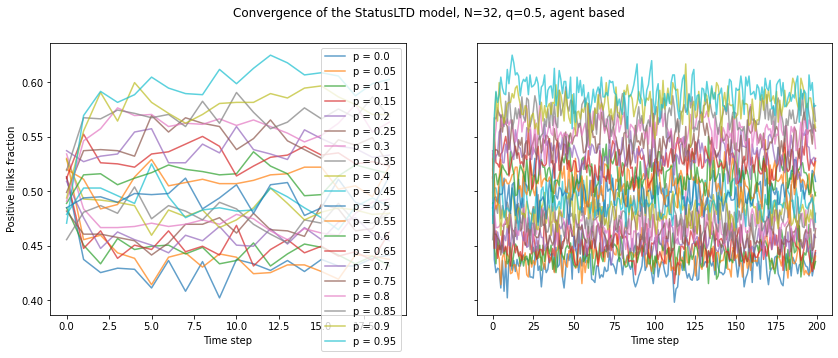

In [8]:
save_conv_plot(status_output,
               '/home/adam/Desktop/StatusLTDConvergence.jpg',
               'Convergence of the StatusLTD model, N=32, q=0.5, agent based')

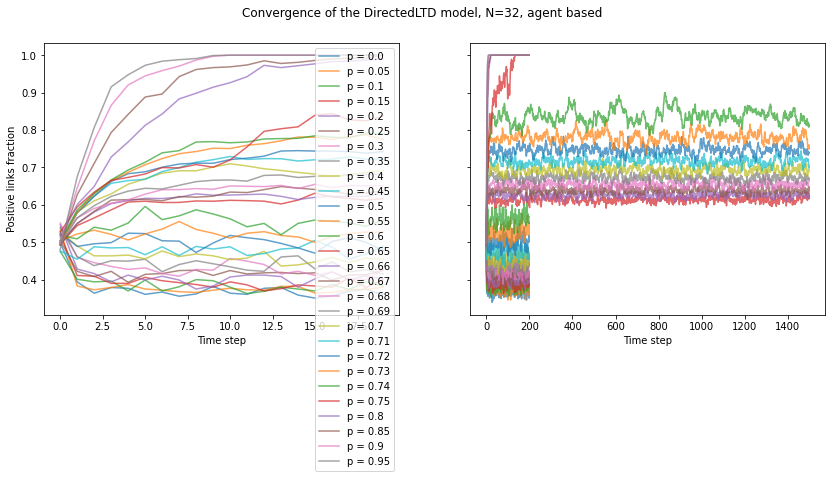

In [9]:
save_conv_plot(d_output,
               '/home/adam/Desktop/DirectedLTDConvergence.jpg',
               'Convergence of the DirectedLTD model, N=32, agent based')

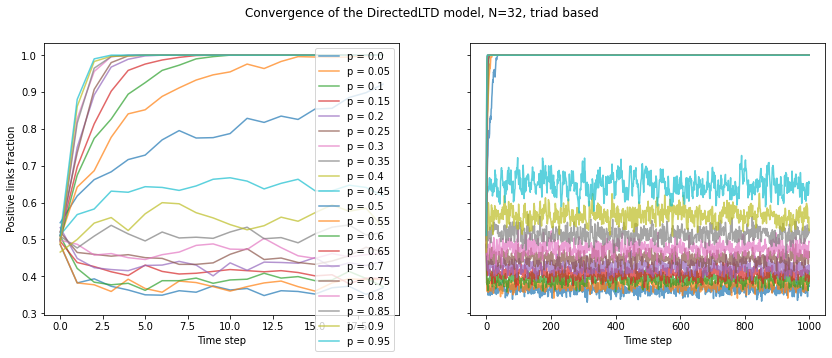

In [10]:
save_conv_plot(dtb_output,
               '/home/adam/Desktop/DirectedLTDConvergence_tb.jpg',
               'Convergence of the DirectedLTD model, N=32, triad based')